# Projet de BIML 
## Sujet : 

In [1]:
import torch
import networkx as nx
import matplotlib.colors as mcolors

Avec lien : 


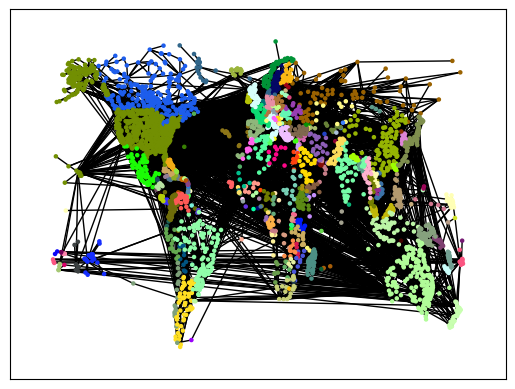

In [2]:
# Lecture du fichier
G = nx.read_graphml('dataset.graphml')

# Association des couleurs des noeuds en fonction du pays
unique_countries = list(set(G.nodes[node]["country"] for node in G.nodes))
colors_tab = dict(zip(unique_countries,mcolors.get_named_colors_mapping()))
node_colors = [colors_tab[G.nodes[node]["country"]] for node in G.nodes]

# Affichage du graphe avec les noeuds placés à leur position géographique
pos_map = {node: (G.nodes[node]["lon"], G.nodes[node]["lat"]) for node in G.nodes}
print("Avec lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors)

Sans lien : 


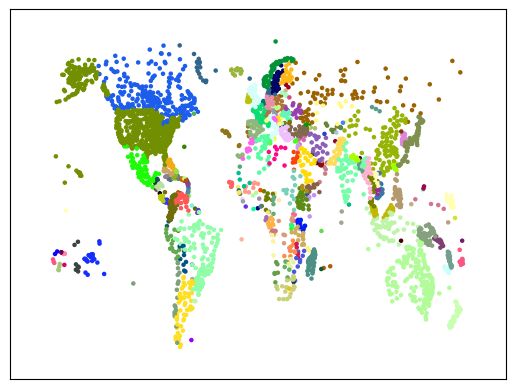

In [3]:
print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')

## Entrainement sur toutes les données

In [4]:

import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
import torch.nn as nn

# Préparation des données
data = []
for node in G.nodes:
    data.append([G.nodes[node]["city_name"], G.nodes[node]["population"]])
    
df = pd.DataFrame(data, columns=["city_name", "population"])

# Encodage des noms de villes
encoder = OneHotEncoder(sparse_output=False)
city_encoded = encoder.fit_transform(df[['city_name']])

# Normalisation de la population
scaler = MinMaxScaler()
population_normalized = scaler.fit_transform(df[['population']])

# Concaténation des données et conversion en tenseur
processed_data = np.hstack((city_encoded, population_normalized))
processed_data = torch.tensor(processed_data, dtype=torch.float)

# Création d'un mappage des noeuds du graphe
node_map = {node: i for i, node in enumerate(G.nodes)}

# Obtention de l'index des arêtes depuis le graphe G
edges = [(node_map[u], node_map[v]) for u, v in G.edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Création d'un objet Data de PyTorch Geometric et division en train/test
data = Data(x=processed_data, edge_index=edge_index)
train_test = train_test_split_edges(data, test_ratio=0.1, val_ratio=0.05)
print(train_test)


c:\Users\tomhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tomhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3363, 3289], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


In [5]:
from torch_geometric.nn import GCNConv, VGAE

# Encoder pour le modèle VGAE
class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out) # Couche de convolution GCN
        self.conv_mu = GCNConv(2 * dim_out, dim_out) # Couche de sortie pour la moyenne
        self.conv_logstd = GCNConv(2 * dim_out, dim_out) # Couche de sortie pour l'écart-type
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    

In [6]:
model = VGAE(Encoder(data.num_features, 16))

# Mise en place du modèle et des données sur le GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Fonctions d'entraînement et de test
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index, epoch):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        val_auc, val_ap = model.test(z, pos_edge_index, neg_edge_index)
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')
        
    return z

num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    
    # Calcul des performances sur le jeu de validation
    z = test(train_test.val_pos_edge_index, train_test.val_neg_edge_index, epoch)
    
# Test final après les 200 epochs pour évaluer les performances
print("Test final : ")
z = test(train_test.test_pos_edge_index, train_test.test_neg_edge_index, num_epochs)

Epoch: 000, Val AUC: 0.8058, Val AP: 0.8201
Epoch: 010, Val AUC: 0.8687, Val AP: 0.8796
Epoch: 020, Val AUC: 0.8646, Val AP: 0.8820
Epoch: 030, Val AUC: 0.8504, Val AP: 0.8778
Epoch: 040, Val AUC: 0.8285, Val AP: 0.8682
Epoch: 050, Val AUC: 0.8316, Val AP: 0.8706
Epoch: 060, Val AUC: 0.8389, Val AP: 0.8750
Epoch: 070, Val AUC: 0.8443, Val AP: 0.8788
Epoch: 080, Val AUC: 0.8484, Val AP: 0.8817
Epoch: 090, Val AUC: 0.8528, Val AP: 0.8837
Epoch: 100, Val AUC: 0.8560, Val AP: 0.8854
Epoch: 110, Val AUC: 0.8598, Val AP: 0.8884
Epoch: 120, Val AUC: 0.8655, Val AP: 0.8928
Epoch: 130, Val AUC: 0.8753, Val AP: 0.9001
Epoch: 140, Val AUC: 0.8882, Val AP: 0.9090
Epoch: 150, Val AUC: 0.8996, Val AP: 0.9177
Epoch: 160, Val AUC: 0.9101, Val AP: 0.9285
Epoch: 170, Val AUC: 0.9182, Val AP: 0.9359
Epoch: 180, Val AUC: 0.9207, Val AP: 0.9387
Epoch: 190, Val AUC: 0.9230, Val AP: 0.9411
Test final : 
Epoch: 200, Val AUC: 0.9185, Val AP: 0.9391


In [7]:
# Suppose qu'on crée un décodeur simple pour prédire la population
class PopulationDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(PopulationDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1) # Couche linéaire
        self.act = nn.ReLU() # Fonction d'activation

    def forward(self, z):
        return self.act(self.fc(z))  # Prédit la population normalisée

# Instanciation du décodeur
decoder = PopulationDecoder(z.size(1)).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.1)

# Fonction de perte
criterion = nn.MSELoss()

# Entraînement du décodeur
def train_decoder():
    decoder.train()
    decoder_optimizer.zero_grad()
    predicted_population = decoder(z)
    population_real = torch.tensor(df['population'].values, dtype=torch.float32, device=device).unsqueeze(1)
    loss = criterion(predicted_population, population_real)
    loss.backward()
    decoder_optimizer.step()
        

# Entraîner le décodeur après avoir obtenu les embeddings latents du modèle VGAE
def test_decoder():
    decoder.eval()
    with torch.no_grad():
        predicted_population = decoder(z)
    return predicted_population

for epoch in range(200):
    train_decoder()
    predicted_population = test_decoder()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Predicted Population: {predicted_population[:5].squeeze().tolist()}')


Epoch: 000, Loss: 0.8453, Predicted Population: [0.4799286425113678, 0.5226604342460632, 0.916415810585022, 0.4853179454803467, 0.4674999713897705]
Epoch: 010, Loss: 0.8453, Predicted Population: [0.8020599484443665, 0.9235061407089233, 1.9870917797088623, 0.8873038291931152, 1.0020582675933838]
Epoch: 020, Loss: 0.8453, Predicted Population: [1.1111888885498047, 1.3097082376480103, 3.0158443450927734, 1.2759358882904053, 1.5194405317306519]
Epoch: 030, Loss: 0.8453, Predicted Population: [1.4186512231826782, 1.694084644317627, 4.040318489074707, 1.6628650426864624, 2.0346693992614746]
Epoch: 040, Loss: 0.8453, Predicted Population: [1.7271718978881836, 2.07963228225708, 5.069016456604004, 2.0509049892425537, 2.5514278411865234]
Epoch: 050, Loss: 0.8453, Predicted Population: [2.038088321685791, 2.4677484035491943, 6.105119705200195, 2.4414241313934326, 3.0714099407196045]
Epoch: 060, Loss: 0.8453, Predicted Population: [2.3513741493225098, 2.858384609222412, 7.148251056671143, 2.83439

Nous partons du principe que les données faussées sont celles étant égales à 10000 car elles sont très nombreuses. Nous allons donc maintenant faire une comparaison entre les données réelles et celle prédites par le modèle. 

In [8]:
# Dénormalisation des populations
predicted_population_denorm = scaler.inverse_transform(predicted_population.cpu().numpy())

# Calcul des écarts entre population réelle et prédite
population_real = df['population'].values.reshape(-1, 1)  # Population réelle non normalisée

threshold = 0.1 * np.mean(population_real)  # Seuil arbitraire pour identifier les anomalies

outliers = np.abs(population_real - predicted_population_denorm) < threshold

# Obtenir les noms des villes suspectes
suspect_cities = df.iloc[outliers]['city_name'].values

for city in suspect_cities:
    print("Villes avec des anomalies de population: "+ city+ " - " + str(df[df['city_name'] == city]['population'].values[0]) )


Villes avec des anomalies de population: Bora Bora - 10000
Villes avec des anomalies de population: Huahine - 10000
Villes avec des anomalies de population: Moorea - 10000
Villes avec des anomalies de population: Raiatea Island - 10000
Villes avec des anomalies de population: Rangiroa Island - 10000
Villes avec des anomalies de population: Rurutu - 10000
Villes avec des anomalies de population: Tikehau Atoll - 10000
Villes avec des anomalies de population: Takaroa - 10000
Villes avec des anomalies de population: Tubuai - 10000
Villes avec des anomalies de population: Manihi - 10000
Villes avec des anomalies de population: Blenheim - 28800
Villes avec des anomalies de population: Hamilton - 902
Villes avec des anomalies de population: Nelson - 29317
Villes avec des anomalies de population: Nuku'alofa - 10000
Villes avec des anomalies de population: Port Vila - 10000
Villes avec des anomalies de population: Wanganui - 10000
Villes avec des anomalies de population: Wellington - 22816
Vill

In [9]:
# pourcentage de villes avec des anomalies
print(f'Pourcentage de villes avec des anomalies détectées: {len(suspect_cities) / len(df) * 100:.2f}%')
# pourcentage de villes avec anomalies de population = 10000 habitants
cpt = 0
for city in suspect_cities:
    cpt += 1 if df[df['city_name'] == city]['population'].values[0] == 10000 else 0
print(f'Pourcentage de villes avec anomalies ayant 10000 de population: {cpt / len(df) * 100:.2f}%')

# pourcentage de ville avec 10000 habitants
print(f'Pourcentage de villes avec 10000 habitants: {len(df[df["population"] == 10000]) / len(df) * 100:.2f}%')

Pourcentage de villes avec des anomalies détectées: 26.20%
Pourcentage de villes avec anomalies ayant 10000 de population: 23.37%
Pourcentage de villes avec 10000 habitants: 49.75%


Sans lien : 


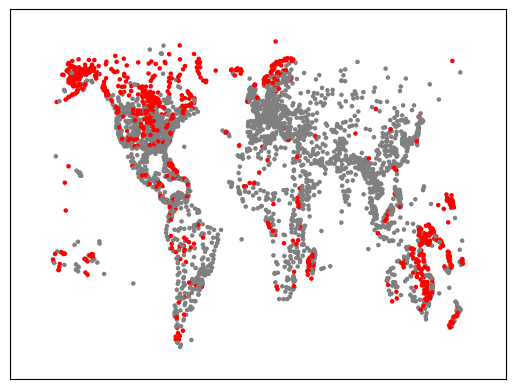

In [10]:
# Visualisation des anomalies
anomalous_nodes = [node_map[node] for node in G.nodes if G.nodes[node]['city_name'] in suspect_cities.tolist()]

node_colors = ['red' if node_map[node] in anomalous_nodes else 'grey' for node in G.nodes]

print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')


In [11]:
with open('anomalies.txt', 'w') as f:
    for city in suspect_cities:
        f.write(city+ " - " + str(df[df['city_name'] == city]['population'].values[0]) + "\n")

Autres anomalies possibles :
- Nom de pays incorrect
- Villes répétées avec attributs identiques ?
- 